In [7]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [8]:
t1_list = sorted(glob.glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/data/TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/data/TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/data/TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/data/TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/data/TrainingData/*/*seg.nii'))

In [ ]:
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)

    #temp_image_t1=nib.load(t1_list[img]).get_fdata()
    #temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)

    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    #temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    #temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    #temp_image_flair=nib.load(flair_list[img]).get_fdata()
    #temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    print(np.unique(temp_mask))
    
    
    #temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_image_t2=temp_image_t2[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    #val, counts = np.unique(temp_mask, return_counts=True)
    

    temp_mask= to_categorical(temp_mask, num_classes=4)

        #np.save('/content/drive/MyDrive/np_images_t1/image_'+str(img)+'.npy', temp_image_t1)
    np.save('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/data/T2_images/image_'+str(img)+'.npy', temp_image_t2)
        #np.save('/content/drive/MyDrive/np_images_t1ce/image_'+str(img)+'.npy', temp_image_t1ce)
        #np.save('/content/drive/MyDrive/np_images_flair/image_'+str(img)+'.npy', temp_image_flair)
    np.save('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/data/masks/mask_'+str(img)+'.npy', temp_mask)
        
   

In [27]:
print('masks shape : ', temp_image_t2.shape)
print('masks type : ', temp_image_t2.dtype)


masks shape :  (128, 128, 128)
masks type :  float64


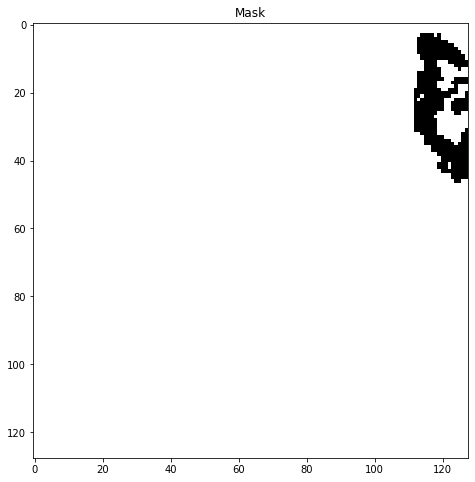

In [13]:
import random
n_slice=random.randint(0, temp_mask.shape[2])

plt.figure(figsize=(12, 8))

#plt.imshow(temp_image_t2[:,:,n_slice], cmap='gray')
#plt.title('Image t2')

plt.imshow(temp_mask[:,:,n_slice])
plt.title('Mask')
plt.show()



In [4]:
!pip install split-folders

In [ ]:
import splitfolders  # or import split_folders

input_folder = '/content/drive/MyDrive/brain tumor segmentation/huzaifa data/data/'
output_folder = '/content/drive/MyDrive/brain tumor segmentation/huzaifa data/validation'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

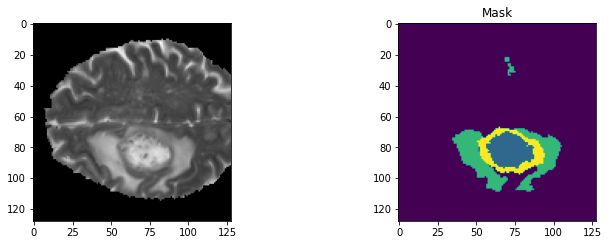

In [22]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

############################################

#Test the generator

from matplotlib import pyplot as plt
import random

train_img_dir = "/content/drive/MyDrive/brain tumor segmentation/huzaifa data/validation/train/T2_images/"
train_mask_dir = "/content/drive/MyDrive/brain tumor segmentation/huzaifa data/validation/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice], cmap='gray')
#plt.title('Image flair')
plt.subplot(222)
#plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
#plt.title('Image t1ce')
#plt.subplot(223)
#plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
#plt.title('Image t2')
#plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/validation/train/masks/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    
    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

#Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss 

##############################################################
#Define the image generators for training and validation

train_img_dir = "/content/drive/MyDrive/brain tumor segmentation/huzaifa data/validation/val/T2_images/"
train_mask_dir = "/content/drive/MyDrive/brain tumor segmentation/huzaifa data/validation/train/masks/"

val_img_dir = "/content/drive/MyDrive/brain tumor segmentation/huzaifa data/validation/val/T2_images/"
val_mask_dir = "/content/drive/MyDrive/brain tumor segmentation/huzaifa data/validation/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
##################################

########################################################################
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()




In [55]:
temp_maskee= to_categorical(test_img, num_classes=3)
temp_maskee.shape

(128, 128, 128, 3)

In [ ]:
!pip install keras_applications
!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D

In [ ]:
import numpy as np


########################
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape
from keras.layers import BatchNormalization
import tensorflow as tf
from torch.nn import MaxUnpool3d
from keras.layers import Conv3D, MaxPooling3D, concatenate, UpSampling3D


def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Conv3D(64, (kernel, kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Conv3D(64, (kernel, kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1= MaxPooling3D(pool_size)(conv_2)

    conv_3 = Conv3D(128, (kernel, kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Conv3D(128, (kernel, kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2 = MaxPooling3D(pool_size)(conv_4)

    conv_5 = Conv3D(256, (kernel, kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Conv3D(256, (kernel, kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Conv3D(256, (kernel, kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3 = MaxPooling3D(pool_size)(conv_7)

    conv_8 = Conv3D(512, (kernel, kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4 = MaxPooling3D(pool_size)(conv_10)

    conv_11 = Conv3D(512, (kernel, kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5 = MaxPooling3D(pool_size)(conv_13)
    print("Build enceder done..")

    # decoder

    unpool_1 = UpSampling3D(pool_size)(pool_5)

    conv_14 = Conv3D(512, (kernel, kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = UpSampling3D(pool_size)(conv_16)

    conv_17 = Conv3D(512, (kernel, kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Conv3D(256, (kernel, kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = UpSampling3D(pool_size)(conv_19)

    conv_20 = Conv3D(256, (kernel, kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Conv3D(256, (kernel, kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Conv3D(128, (kernel, kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = UpSampling3D(pool_size)(conv_22)

    conv_23 = Conv3D(128, (kernel, kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Conv3D(64, (kernel, kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = UpSampling3D(pool_size)(conv_24)

    conv_25 = Conv3D(64, (kernel, kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Conv3D(n_labels, (1, 1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    '''conv_26 = Reshape(
            (input_shape[0]*input_shape[1], n_labels),
            input_shape=(input_shape[0], input_shape[1], n_labels))(conv_26)'''

    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model



model = segnet(input_shape=(128,128,128), n_labels=4)

model.summary()
print(model.input_shape)
print(model.output_shape)

In [50]:
import tensorflow as tf

In [53]:


from __future__ import absolute_import
from __future__ import print_function
import os
import numpy as np
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.utils import np_utils
from keras.applications import imagenet_utils
import tensorflow.keras.backend as k
K.set_image_dim_ordering('th')


def SegNet(input_shape=(128, 128, 128), classes=4):
    # c.f. https://github.com/alexgkendall/SegNet-Tutorial/blob/master/Example_Models/bayesian_segnet_camvid.prototxt
    img_input = Input(shape=input_shape)
    x = img_input
    # Encoder
    x = Convolution2D(64, 3, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2),dim_ordering="th")(x)
    
    x = Convolution2D(128, 3, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2),dim_ordering="th")(x)
    
    x = Convolution2D(256, 3, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2),dim_ordering="th")(x)
    
    x = Convolution2D(512, 3, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Decoder
    x = Convolution2D(512, 3, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(256, 3, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(128, 3, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(64, 3, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(classes, 1, 1, padding="valid")(x)
    x = Reshape((input_shape[0]*input_shape[1], classes))(x)
    x = Activation("softmax")(x)
    model = Model(img_input, x)
    return model


AttributeError: ignored

In [31]:
import tensorflow as tf


In [32]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)
#######################################################################
#Fit the model 

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size



In [46]:
model = SegNet(input_shape = (128,128,128), classes = 4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=30,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

TypeError: ignored